I used these githubs:

LIUY/ model_new/ 850

taoxugit / code / datasets

yunjey / model

In [ ]:
import os
import numpy as np
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
from torch.utils.data import Dataset
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage import transform
import torch
import cv2
import torchvision.models as models
import numpy.random as random
import torch
import torch.nn as nn
from functools import partial
import math

import torch.nn.functional as F
from collections import OrderedDict
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.functional as func
from torch.nn.modules.utils import _pair
from torch.utils import data

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

In [4]:
import tarfile
tar = tarfile.open("/content/drive/My Drive/Deep_learning/Model Explanation/CUB_200_2011.tgz")
tar.extractall()
tar.close()

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Deep_learning/Model Explanation/birds.zip', 'r')
zip_ref.extractall('/content/home/cub')
zip_ref.close()

In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/home/cub/birds/text.zip', 'r')
zip_ref.extractall('/content/home/cub')
zip_ref.close()

In [70]:
#text path
path_root = '/content/home/cub/text/'
filename=[]

folder_class = os.listdir(path_root)
for i in range (len(folder_class)):
  path_file = path_root + folder_class[i]
  file_calss = os.listdir(path_file)
  for j in range(len(file_calss)):
    final_path = path_root + folder_class[i] + '/' + file_calss[j]
    filename.append(final_path)


# images path
path_root = '/content/CUB_200_2011/images/'
filename_img=[]

folder_class = os.listdir(path_root)
for i in range (len(folder_class)):
  path_file = path_root + folder_class[i]
  file_calss = os.listdir(path_file)
  for j in range(len(file_calss)):
    final_path = path_root + folder_class[i] + '/' + file_calss[j]
    filename_img.append(final_path)


# Create filenames list for text and image data without train an test
text_root = '/content/home/cub/text/'
img_root = '/content/CUB_200_2011/images/'

filename_text=[]
filename_img=[]

folder_class = os.listdir(text_root)
for i in range (len(folder_class)):
  path_file_text = text_root + folder_class[i]

  file_calss = os.listdir(path_file_text)
  for j in range(len(file_calss)):
    final_path_text = text_root + folder_class[i] + '/' + file_calss[j]
    final_path_img = img_root + folder_class[i] + "/" + file_calss[j].split(".")[0] + ".jpg"
    filename_text.append(final_path_text)
    filename_img.append(final_path_img)

**Create filenames list for text and image data (train, test)  **






In [78]:
text_root = '/content/home/cub/text/'
img_root = '/content/CUB_200_2011/images/'

a = []
with open ("/content/CUB_200_2011/images.txt", "r")as f:  
  sample = f.read().split("\n")
  for s in sample:
    if len(s) > 0:
      a.append(s)

b = []
with open ("/content/CUB_200_2011/train_test_split.txt", "r")as f:
  sample = f.read().split("\n")
  for s in sample:
    if len(s) > 0:
      b.append(s)


filename_text_train = []
filename_text_test = []
filename_img_train = []
filename_img_test = []


for i in range (len(a)):
  name_img = a[i].split(" ")[1]
  name_text = name_img.split("jpg")[0] + "txt"

  if b[i].split(" ")[-1] == "1":
    filename_text_train.append(text_root + name_text)
    filename_img_train.append(img_root + name_img)

  else:
    filename_text_test.append(text_root + name_text)
    filename_img_test.append(img_root + name_img)


**Create Class for Dataset**

In [79]:
class TextDataset(Dataset):
    def __init__(self, text_dir, img_dir, max_seq_length):

        self.embeddings_num = 10
        self.data = []
        self.data_dir = text_dir
        self.img_dir = img_dir
        self.number_example = len(self.data_dir)
        self.max_seq_length = max_seq_length
        self.captions, self.ixtoword,self.wordtoix, self.n_words = self.load_text_data(text_dir)  



    def load_img (self, filename):
        img = cv2.imread(filename)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img


    def load_captions(self, filenames):
        all_captions = []
        for i in range(len(filenames)):
            cap_path = filenames[i]
            with open(cap_path, "r") as f:
                captions = f.read().split('\n')
                cnt = 0
                for cap in captions:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace("\ufffd\ufffd", " ")
                    # picks out sequences of alphanumeric characters as tokens
                    # and drops everything else
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())
                    # print('tokens', tokens)
                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    tokens_new.append('<start>')
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    # tokens_new.append('<end>')
                    all_captions.append(tokens_new)
                    cnt += 1
                    if cnt == self.embeddings_num:
                        break
                if cnt < self.embeddings_num:
                    print('ERROR: the captions for %s less than %d'
                          % (filenames[i], cnt))
        return all_captions


    def build_dictionary(self, train_captions):
        word_counts = defaultdict(float)
        captions = train_captions 
        for sent in captions:
            for word in sent:
                word_counts[word] += 1

        vocab = [w for w in word_counts if word_counts[w] >= 0]

        ixtoword = {}
        ixtoword[0] = '<end>'
        wordtoix = {}
        wordtoix['<end>'] = 0
        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1

        train_captions_new = []
        for t in train_captions:
            rev = []
            for w in t:
                if w in wordtoix:
                    rev.append(wordtoix[w])
            # rev.append(0)  # do not need '<end>' token
            train_captions_new.append(rev)


        return [train_captions_new,ixtoword, wordtoix, len(ixtoword)]   # train_captions_naw : our captions after numeralization

    def load_text_data(self, data_dir):
        
        train_captions = self.load_captions(data_dir)            
        train_captions, ixtoword, wordtoix, n_words = self.build_dictionary(train_captions)

        return  train_captions, ixtoword, wordtoix, n_words


    def get_caption(self, sent_ix):          #select sentence and chosse max (max_seq_length) words
       
       sent_caption = self.captions[sent_ix]
       sent_caption = np.array(sent_caption)
       if (sent_caption == 0).sum() > 0:
         print('ERROR: do not need END (0) token', sent_caption)
        
       num_words = sent_caption.shape[0]          # the size of caption
       x = np.zeros((self.max_seq_length, 1), dtype='int64')
       x_len = num_words

       if num_words <= self.max_seq_length:
          x[:num_words, 0] = sent_caption


       else:
          ix = list(np.arange(num_words))  # 1, 2, 3,..., maxNum
          np.random.shuffle(ix)
          ix = ix[:self.max_seq_length]
          ix = np.sort(ix)
          x[:, 0] = sent_caption[ix]
          x_len = self.max_seq_length  

       return x, x_len

    def __getitem__(self, index):

        img = self.load_img(self.img_dir[index])        # reading our image

        sent_ix = random.randint(0, self.embeddings_num)
        new_sent_ix = index * self.embeddings_num + sent_ix
        caps, cap_len = self.get_caption(new_sent_ix)

        return  img, caps, cap_len


    def __len__(self):
        return len(self.data_dir)

**Dataset & Dataloader**

In [88]:
max_seq_length = 40
train_data = TextDataset(filename_text_train, filename_img_train, max_seq_length)
test_data = TextDataset(filename_text_test, filename_img_test, max_seq_length)

train_loader = Data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=16)
test_loader = Data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=16)

tensor([[[ 1],
         [36],
         [29],
         [33],
         [22],
         [44],
         [18],
         [14],
         [21],
         [22],
         [10],
         [34],
         [50],
         [ 2],
         [51],
         [52],
         [ 2],
         [14],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0]]])
tensor([18])


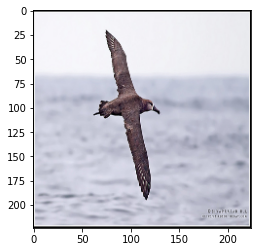

In [85]:
img, cap, len_cap = next(iter(train_loader))
plt.imshow(img[0])
print(cap)
print(len_cap)

**Image model**

In [89]:
class Vgg_16 (nn.Module):
    def __init__(self, embed_size): 
        super(Vgg_16, self).__init__()

        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier[6] = nn.Linear(4096,embed_size)  # embed_size = 128

    def forward (self, x):
        x = self.vgg(x)
        return x


**Image_captioning Model**

In [108]:
class MLP_RNN_OneLSTM_Res(nn.Module):
    def __init__(self, vggSize,embed_size,vocab_size,hidden_size,num_layers,max_seq_length):  # (embed_size, hidden_size, vocab_size, num_layers, max_seq_length=50):
        """Set the hyper-parameters and build the layers."""
        super(MLP_RNN_OneLSTM_Res, self).__init__()
        self.linear1 = nn.Linear(vggSize, embed_size)  # image feature is fed into the second LSTM
        self.word_embed = nn.Embedding(vocab_size, embed_size)
        ## LSTM setting
        self.lstm1 = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc_cls = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()

    def init_weights(self):
        self.word_embed.weight.data.uniform_(-0.1, 0.1)
        self.linear1.weight.data.uniform_(-0.1, 0.1)
        self.linear1.bias.data.fill_(0)
        self.fc_cls.weight.data.uniform_(-0.1, 0.1)
        self.fc_cls.bias.data.fill_(0)

    def forward(self, img_vgg, wordID, lengths):

        wordID = wordID.view(wordID.size(0),self.max_seq_length)           # we can make the vocab vectors ready for embeddings
        embeddings = self.word_embed(wordID)                  

        img_vgg = self.relu(self.linear1(img_vgg))         # we can make the images vectors ready for embeddings
        img_vgg = img_vgg.unsqueeze(1)

        lstm1_input = torch.cat((img_vgg, embeddings), 1)       # we concatenate vocab vector and image vector
        packed_embed = pack_padded_sequence(lstm1_input, lengths, batch_first=True, enforce_sorted=False)
        lstm1_hiddens, _ = self.lstm1(packed_embed)
        lstm1_hiddens = self.dropout(lstm1_hiddens[0])
        outputs = self.fc_cls(lstm1_hiddens)

        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        features = self.relu(self.linear1(features))
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm1(inputs, states) 
            outputs = self.fc_cls(hiddens.squeeze(1))           # we will transfer the hidden vector to vocab_size vector
            _, predicted = outputs.max(1)                       # we can find the word which is predicted 
            sampled_ids.append(predicted)
            inputs = self.word_embed(predicted)                 # we want to embed the output word to send it to the next lstm
            inputs = inputs.unsqueeze(1)                       
        sampled_ids = torch.stack(sampled_ids, 1)               # concatenate the words in order to create our sentence
        return sampled_ids

In [114]:
model =  MLP_RNN_OneLSTM_Res(vggSize = 1024,embed_size = 128,vocab_size = 4057,hidden_size =128,
                             num_layers =2,max_seq_length=max_seq_length).cuda()
model_vgg_16 = Vgg_16(1024).cuda()

In [115]:
error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [121]:
for epoch in range(20):
    for i, (images, cap , cap_len) in enumerate(train_loader):
        
        # we will give images to the vgg model       
        # it will gives us vectors with embed size

        images = images.view(images.size(0), 3, 224, 224)
        images = images.float().cuda()
        img = model_vgg_16(images)                            # the output of vgg

        cap = cap.long().cuda()
        img = img.float().cuda()
        cap_len = cap_len.long().cuda()

        optimizer.zero_grad()
        
        outputs = model(img,cap,cap_len)

        cap = cap.view(cap.size(0), max_seq_length)           # for estimating the loss

        lstm_targets = pack_padded_sequence(cap, cap_len, batch_first=True, enforce_sorted= False)[0].cuda()

        loss = error(outputs, lstm_targets)

        if i%20 == 0:
          print ("num_epochs: ", epoch)
          print("num_iteration: ", i)
          print("loss: ", loss)

        loss.backward()
        
        optimizer.step()


        if i%500 ==0 :
          for j, (images, cap , cap_len) in enumerate(test_loader):
            if j<2 :
              images = images.view(images.size(0), 3, 224, 224)
              images = images.float().cuda()
              img = model_vgg_16(images) 
              img = img.float().cuda()    # vector size = 1024

              sampled_ids = model.sample(img)
              sampled_ids = sampled_ids[0].cpu().numpy()         # we want to show one of the captions
              sampled_caption = []
              for word_id in sampled_ids:
                  word = train_data.ixtoword[word_id]         # we will fint the word related to this number
                  sampled_caption.append(word)
                  if word == '<end>':
                      break
              sentence = ' '.join(sampled_caption)
              
              # Print out the image and the generated caption
              print (10 * "****")

              print (sentence)

              print (10 * "****")

            else :
              break



num_epochs:  0
num_iteration:  0
loss:  tensor(8.3159, device='cuda:0', grad_fn=<NllLossBackward>)
****************************************
snacks snacks snacks snacks mo mo rown sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin
****************************************
****************************************
trailing supercillaries supercillaries supercillaries supercillaries bag bag shorter shorter protruding sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin sequin
****************************************
num_epochs:  0
num_iteration:  20
loss:  tensor(8.3056, device='cuda:0', grad_fn=<NllLossBackward>)
num_epochs:  0
num_iteration:  40
loss:  tensor(8.312

In [ ]:
cap_len

In [ ]:
 img = torch.zeros(1,1024)

In [ ]:
img.size()